https://chatgpt.com/share/68fcdf1e-f778-800f-b7e6-9abdacb64514

#### You taught how the input looks like for a DQN, but what about the output? Is output a real number which give estimate of the value function?

**V=3**

Exactly — the **output of a Deep Q-Network (DQN)** represents **the estimated Q-values**, i.e., the **expected future cumulative reward** for each possible action in the current state.

---

### **1. Input → Output structure**

* **Input:** one state vector (or image) → ( s_t )
* **Output:** a vector of **Q-values**, one for each possible **discrete action** ( a_i ):
  $$Q(s_t; \theta) = [Q(s_t, a_1), Q(s_t, a_2), ..., Q(s_t, a_n)]$$

So if your environment has, say, 4 possible actions (e.g., *up, down, left, right*), the output layer will have **4 neurons**.

---

### **2. What each output number means**

Each element ( Q(s_t, a_i) ) is a **real number** —
an *estimate* of the **expected discounted return** starting from state ( s_t ), taking action ( a_i ), and following the policy thereafter.

Mathematically:
$$Q^*(s_t, a_t) = \mathbb{E} \left[ \sum_{k=0}^{\infty} \gamma^k r_{t+k+1} \ \middle| \ s_t, a_t \right]$$

---

### **3. Action selection**

The agent picks the action with the highest predicted Q-value:
$a_t = \arg\max_{a} Q(s_t, a; \theta)$

or, during exploration, it may randomly select an action (ε-greedy).

---

### **Example**

If the network outputs:

```
Q(s_t) = [2.5, -0.8, 1.2, 3.7]
```

and your action space = `[left, right, up, down]`,
then:

* ( Q(s_t, \text{down}) = 3.7 ) → the best estimated return
* The agent will choose **“down”** (unless it’s exploring).

---

### **Summary**

Yes — DQN outputs **a vector of real numbers**, each one representing the **predicted value of the return** (expected future reward) for each **possible discrete action** in the given state.


### Can you show me a step by step process by showing input and output in tabular fashion as before?

# Step-by-step example (V=3)

I'll show a short, concrete sequence using one sampled minibatch (two transitions) and numeric Q-values so you can see exactly how the input (transitions) maps to DQN outputs and to the training target. I’ll use these settings:

* Discount (\gamma = 0.99)
* Target network is separate and frozen for target computation.
* Loss = squared TD error ((y - Q(s,a))^2).
* We show Q-values **before** and **after** a single gradient update (illustrative — actual update depends on optimizer, learning rate, gradients).

---

## 0) Sampled minibatch (input)

Two transitions sampled from replay memory:

| idx | State (s_t)     | Action (a_t) | Reward (r_t) | Next state (s_{t+1}) | Done |
| --- | --------------- | ------------ | ------------ | -------------------- | ---- |
| 0   | [0.1, 0.5, 0.7] | 2            | 1.0          | [0.2, 0.6, 0.8]      | 0    |
| 1   | [0.4, 0.2, 0.9] | 0            | 0.5          | [0.3, 0.1, 0.4]      | 1    |

---

## 1) Forward pass (network outputs Q(s) for each state)

The **main Q-network** produces a Q-vector per state (one value per discrete action). Suppose action space size = 4. Example outputs (before update):

| idx | (Q_{\text{main}}(s_t)) (vector) | chosen (Q_{\text{main}}(s_t,a_t)) |
| --- | ------------------------------- | --------------------------------- |
| 0   | [2.5, −0.8, **1.2**, 3.7]       | 1.2 (action 2)                    |
| 1   | [0.9, 0.3, −0.2, 0.1]           | 0.9 (action 0)                    |

(we bold the entry corresponding to the taken action)

The **target network** (parameters (\theta^-)) gives Q-values for next states:

| idx | (Q_{\text{target}}(s_{t+1})) (vector) | (\max_{a'} Q_{\text{target}}(s_{t+1},a')) |
| --- | ------------------------------------- | ----------------------------------------- |
| 0   | [2.0, 0.5, 1.5, 3.0]                  | 3.0                                       |
| 1   | [0.2, −0.1, 0.0, 0.4]                 | 0.4                                       |

---

## 2) Compute TD targets (y)

Use (y = r + \gamma (1 - done) \cdot \max_{a'} Q_{\text{target}}(s_{t+1}, a'))

Compute numerically (do arithmetic precisely):

* For idx 0:
  (y_0 = 1.0 + 0.99 \times 3.0 = 1.0 + 2.97 = 3.97).

* For idx 1: done = 1 so no bootstrap term:
  (y_1 = 0.5 + 0.99 \times 0 \times 0.4 = 0.5).

So targets: ([3.97, 0.5]).

---

## 3) TD errors and loss

TD error per sample: (\delta = y - Q_{\text{main}}(s,a))

* idx 0: (\delta_0 = 3.97 - 1.2 = 2.77).
  Squared loss: (2.77^2 = 7.6729).

* idx 1: (\delta_1 = 0.5 - 0.9 = -0.4).
  Squared loss: ((-0.4)^2 = 0.16).

Batch loss (mean) = ((7.6729 + 0.16)/2 = 3.91645).

---

## 4) Backpropagation and parameter update (conceptual)

* Compute gradients of loss w.r.t network parameters; only the Q-value of the taken actions directly contributes to the TD loss (via the network outputs for those actions).
* Perform an optimizer step (e.g., SGD/Adam). This will move network outputs (Q_{\text{main}}(s,a)) **toward** their targets (y).

For illustration, suppose after one gradient step the network's predicted Q-values update as follows (toy numbers to show direction):

| idx |  (Q_{\text{main}}) before |       (Q_{\text{main}}) after |
| --- | ------------------------: | ----------------------------: |
| 0   | [2.5, −0.8, **1.2**, 3.7] |   [2.6, −0.75, **2.0**, 3.72] |
| 1   | [**0.9**, 0.3, −0.2, 0.1] | [**0.86**, 0.31, −0.19, 0.11] |

Notes:

* For idx 0, the action 2 value moved from **1.2** → **2.0**, closer to target 3.97 (one step of many).
* For idx 1, because the TD error was negative (predicted > target), action 0 value moved from 0.9 → 0.86 (decreased toward 0.5).

---

## 5) Repeat: store new transitions, sample, train

* Continue interacting with the environment, appending new transitions to replay memory (old ones overwritten when buffer full).
* Periodically (or every step) sample new minibatches and repeat the above steps.
* Every so often copy main network parameters to the target network (Fixed Q-Target), or use smoother updates (Polyak averaging).

---

## Compact pipeline (one-line per stage)

1. Collect transitions → store ((s,a,r,s',done)) in replay buffer.
2. Sample minibatch (B) from buffer.
3. Forward pass main network: get (Q_{\text{main}}(s)) vectors.
4. Forward pass target network on (s'): get $max_{a'} Q_{\text{target}}(s',a')$.
5. Compute targets $y = r + \gamma(1-done)\max Q_{\text{target}}(s',a')$.
6. Compute loss $frac{1}{|B|}\sum (y - Q_{\text{main}}(s,a))^2$.
7. Backprop + optimizer step → update parameters.
8. Periodically update target network. Repeat.

---

### say number of states are 100, number of actions are 4, reward is a single number, done is boolean. Then in input layer we should have 100+4+1+100+1 = 206 neurons? 

That’s a great question — and this is a **common confusion** point.

✅ **Short answer:**
No — the **input layer** of the DQN does **not** have 206 neurons.
It only takes **the current state** as input (so 100 neurons in your example).

---

### **Why**

The DQN is a **function approximator for Q(s, a)** —
it learns to predict a Q-value *given a state* for *all actions* simultaneously.

So at training time:

* You feed only the **state vector** (size = 100) into the network.
* The **output layer** has 4 neurons → one Q-value per action.

---

### **Where (state, action, reward, next_state, done)** come in

Those other elements are used **outside the network** to compute the loss:

| Component    | Used for                  | Role                                               |
| ------------ | ------------------------- | -------------------------------------------------- |
| `state`      | Input to network          | Compute predicted Q(s, a)                          |
| `action`     | Index                     | Select Q-value corresponding to taken action       |
| `reward`     | Target calc               | Used in TD target ( y = r + γ(1-done)\max Q'(s') ) |
| `next_state` | Input to *target* network | Compute next-state Q-values                        |
| `done`       | Mask                      | Prevent bootstrapping after episode ends           |

Only **state** (and next_state during target computation) are passed *through* a neural network.
The rest are **scalars** used in the loss formula, not as part of the input layer.

---

### **So in your example**

* **Input neurons:** 100 (state dimension)
* **Output neurons:** 4 (number of actions)

The rest (`reward`, `done`, `next_state`) are used *outside* the model during the training step, not fed into the DQN input layer.


### So in this above example of DQN (value based method) if on the output layer, if we just take the softmax, will not it actually become a Policy based method? Just thinking loud

Excellent thinking — you’re connecting the dots perfectly 👏

Let’s unpack this carefully (V=3):

---

### **1. What happens if you apply softmax on DQN outputs**

The DQN’s raw outputs are **Q-values** — real numbers representing *expected cumulative reward* for each action.
If you pass them through a **softmax**, you convert them into **probabilities over actions**:

$pi(a|s) = \frac{e^{Q(s,a)}}{\sum_{a'} e^{Q(s,a')}}$

That *looks* like a policy distribution, and in a sense, it **can** be used as one.

---

### **2. But why it’s not the same as a policy-based method**

The key difference is in **how learning happens**:

| Aspect              | **Value-based (DQN)**                                  | **Policy-based (REINFORCE, PPO, etc.)**       |
| ------------------- | ------------------------------------------------------ | --------------------------------------------- |
| Output meaning      | Q-values (expected return per action)                  | Action probabilities                          |
| Optimization target | Minimizes TD error between predicted & target Q-values | Maximizes expected reward via policy gradient |
| Training signal     | From Bellman equation                                  | From sampled returns or advantage estimates   |
| Exploration         | ε-greedy or Boltzmann over Q-values                    | Sampling directly from learned policy         |

So even if you softmax DQN’s outputs, you’re **not changing its objective** — it’s still learning Q-values, not a policy distribution explicitly.

---

### **3. Why softmax on Q-values is sometimes used**

You can indeed **use softmax(Q)** for *action selection*:

* That’s called **Boltzmann (softmax) exploration**, where actions are chosen stochastically with temperature ( \tau ):
  $$P(a|s) = \frac{e^{Q(s,a)/\tau}}{\sum_{a'} e^{Q(s,a')/\tau}}$$
  It smooths action selection instead of hard argmax, encouraging exploration.

But note — the **network is still trained using TD loss**, not policy gradient.

---

### **4. Summary**

* ✅ Softmax(Q) → gives a distribution that *can act like a policy*.
* ❌ But it **does not make DQN a policy-based method**, since learning still happens via **value-function regression**, not **policy optimization**.

Think of it this way:

> “Softmax on Q-values can *produce* a policy, but not *train* one.”

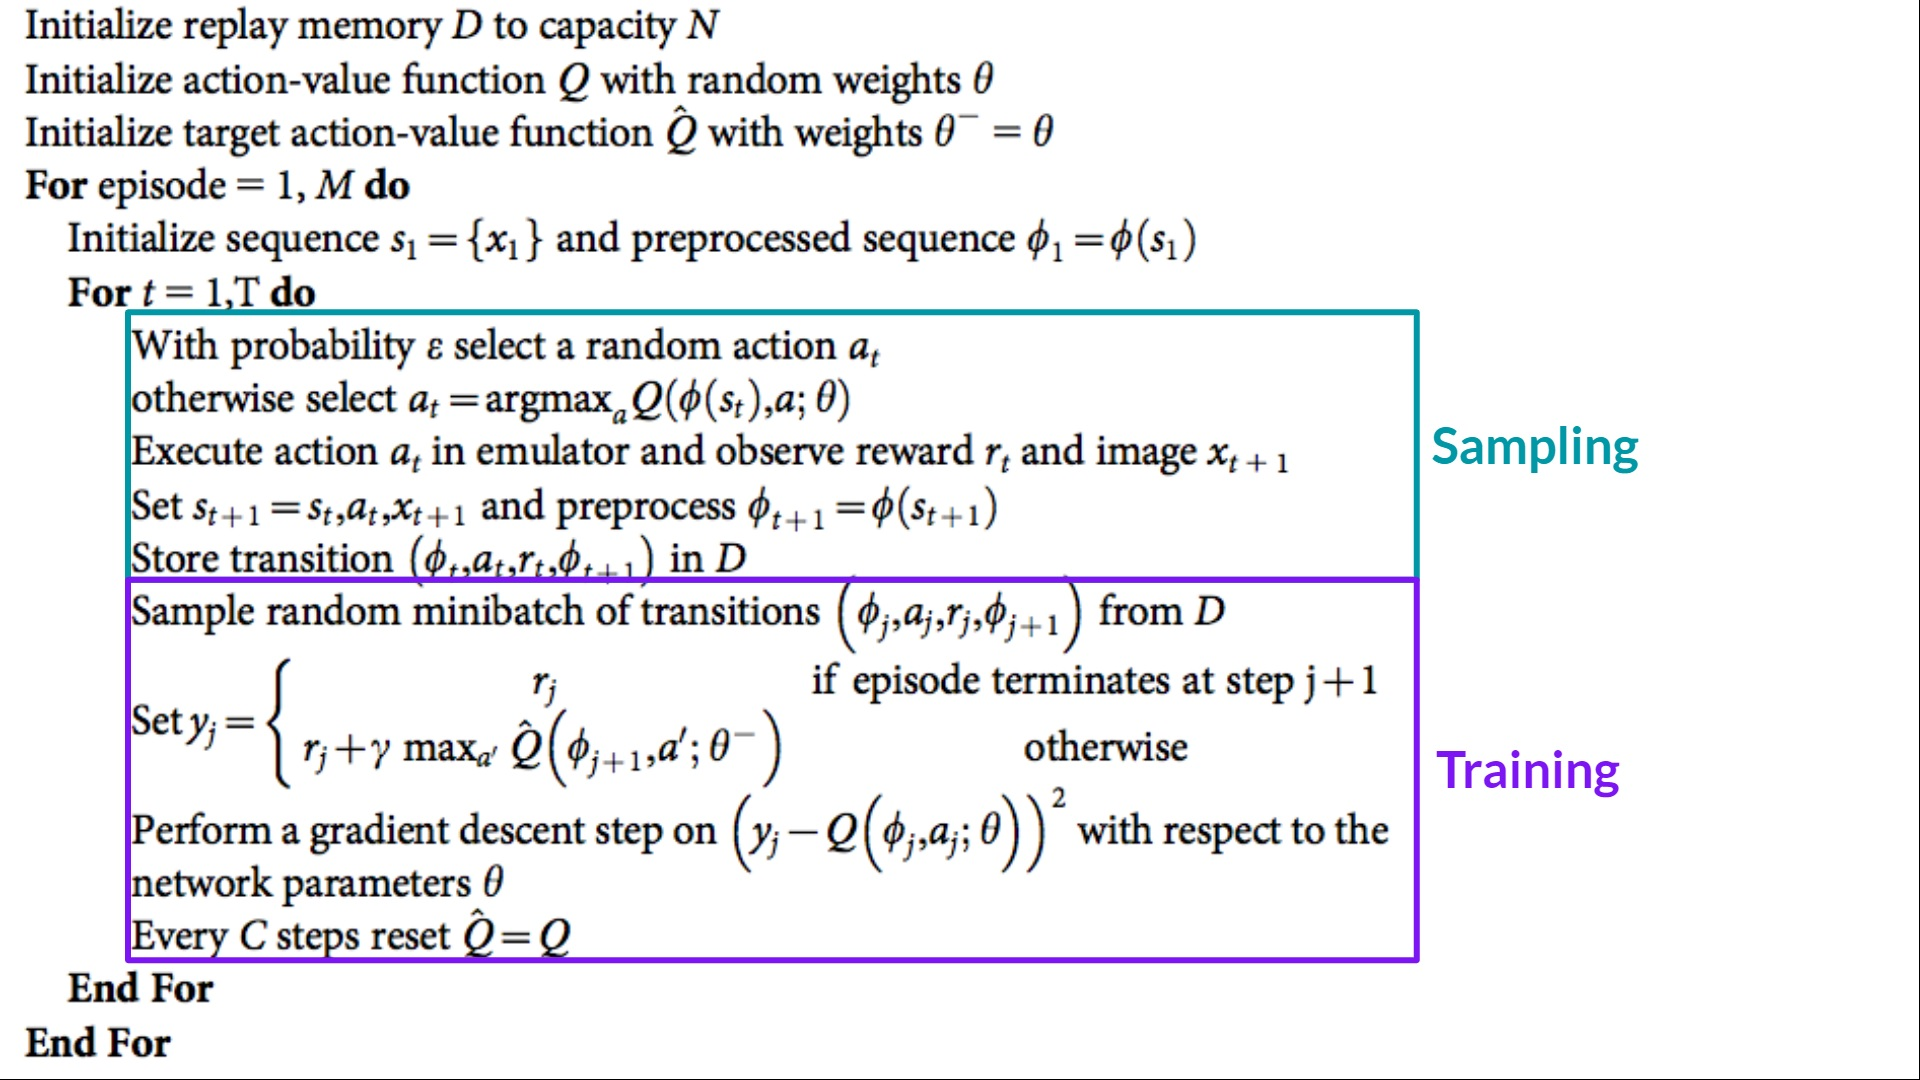

In [4]:
from IPython.display import Image
Image(filename=r"c:\Users\ytiam\Downloads\sampling-training.jpg")

#### What is phi in this above algorithm?

Excellent question — and this is an important subtlety in the DQN (Deep Q-Network) algorithm.

In the image you shared (from the original **DeepMind DQN paper**),

**ϕ (phi)** represents the **preprocessed state representation** that is fed into the neural network.

Let’s unpack this step by step:

---

### 🔹 Meaning of ϕ(s)

* In DQN, **ϕ(s)** is a *feature representation* of the state ( s ).
* It’s a function ( $\phi : S \rightarrow \mathbb{R}^n$ ) that maps the raw environment state into a format suitable for the network input.

---

### 🔹 Why use ϕ(s) instead of s?

In many RL environments (like Atari), a single raw observation (e.g., one game frame) isn’t enough to capture motion or dynamics — because one image doesn’t show velocity or direction of movement.
So, **ϕ(s)** often **stacks multiple recent frames** to give temporal context.

For example:

* ( s_t ) = current raw frame (84×84 grayscale)
* ( $\phi(s_t) = [x_{t−3}, x_{t−2}, x_{t−1}, x_t]$ ), i.e., 4 stacked frames
  → Shape becomes **(4, 84, 84)** instead of (1, 84, 84)

---

### 🔹 So, concretely:

| Symbol                      | Meaning                                                                          |
| :-------------------------- | :------------------------------------------------------------------------------- |
| ( s_t )                     | Raw environment state (e.g., one frame)                                          |
| ( \phi(s_t) )               | Processed input (e.g., stacked and normalized frames)                            |
| ( Q(\phi(s_t), a; \theta) ) | Q-value predicted by the neural net for action *a* given processed state *ϕ(sₜ)* |

---

### 🔹 TL;DR

ϕ (phi) = **preprocessed or feature-transformed version of the state**, used as the input to the Q-network.
It helps the network better represent the temporal and spatial information needed to estimate Q-values accurately.